In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn import metrics

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli, Normal
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm

from plotting import make_vae_plots

CMNIST_list = torch.load("data/ColoredMNIST/train1.pt")
CMNIST = pd.DataFrame(CMNIST_list, columns = ["image", "label"])

images = CMNIST.iloc[:,0]
labels_df = CMNIST.iloc[:,1]
labels = torch.tensor(labels_df)

c:\Users\bends\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms import ToTensor

transform_to_tensor = ToTensor()
transform_to_tensor(images[0]).shape

torch.Size([3, 28, 28])

# Plotting function

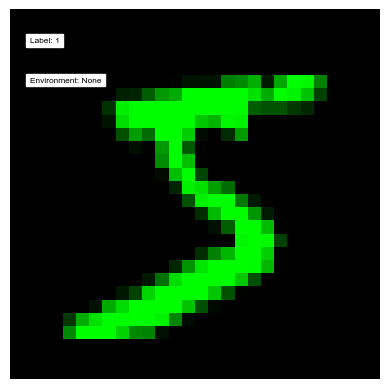

In [3]:
def show_CMNIST(image, label, environment):
    """Show image with landmarks"""
    plt.figure
    plt.imshow(image)
    plt.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 6)
    plt.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 6)
    plt.axis('off')
    plt.show
    plt.pause(0.001)  # pause a bit so that plots are updated

show_CMNIST(images[0], labels[0], None)

In [4]:
class CMNISTDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pt_file, environment=None, transform=None):
        """
        Args:
            pt_file (string): Path to the pt file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            environment (integer): Integer indicating the environment the data comes from
        """
        self.CMNIST_frame = pd.DataFrame(torch.load(pt_file))
        self.transform = transform
        self.environment = environment

    def __len__(self):
        return len(self.CMNIST_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.CMNIST_frame.iloc[idx, 0]
        label = self.CMNIST_frame.iloc[idx, 1]
        sample = {'image': image, 'label': label, "environment": self.environment}

        if self.transform:
            sample = {'image': self.transform(image), 'label': label, "environment": self.environment}

        return sample

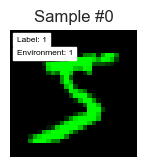

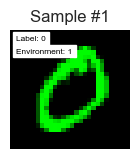

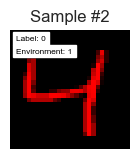

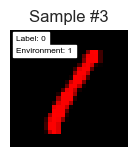

In [5]:
cmnist_data = CMNISTDataset(pt_file = "data/ColoredMNIST/train1.pt", environment = 1)

fig = plt.figure()

for i in range(len(cmnist_data)):
    sample = cmnist_data[i]

    #print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_CMNIST(**sample)

    if i == 3:
        plt.show()
        break

In [6]:
cmnist_data1 = CMNISTDataset(pt_file = "data/ColoredMNIST/train1.pt"
                            , environment = 1
                            , transform = transform_to_tensor)
cmnist_data2 = CMNISTDataset(pt_file = "data/ColoredMNIST/train2.pt"
                            , environment = 2
                            , transform = transform_to_tensor)
train_loader = DataLoader(ConcatDataset([cmnist_data1, cmnist_data2]), batch_size=256, num_workers=0, drop_last = True)

cmnist_test_data = CMNISTDataset(pt_file = "data/ColoredMNIST/test.pt"
                                 , environment = 3
                                 , transform = transform_to_tensor)
test_loader = DataLoader(cmnist_test_data, batch_size = 512, num_workers = 0, drop_last = True)

0 torch.Size([256, 3, 28, 28]) torch.Size([256])
1 torch.Size([256, 3, 28, 28]) torch.Size([256])
2 torch.Size([256, 3, 28, 28]) torch.Size([256])
3 torch.Size([256, 3, 28, 28]) torch.Size([256])


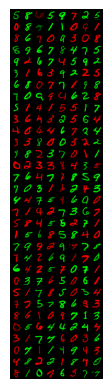

In [7]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# iVAE:

In [12]:
p = Bernoulli(logits=torch.zeros((1000,)))


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        eps = torch.empty_like(self.mu).normal_()
        return self.mu + self.sigma * eps
    # <- your code    
        #return self.mu + self.sigma * self.sample_epsilon() # <- your code    
    
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return torch.normal(mean = self.mu, std = self.sigma)

    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return - ((z - self.mu)**2)/(2*self.sigma**2) - torch.log(self.sigma) - math.log(math.sqrt(2 * math.pi)) # <- your code
    
    def mu(self):
        return(self.mu, self.sigma)
    #def log_prob(self, z:Tensor) -> Tensor:
    #    """return the log probability: log `p(z)`"""
    #    dummy = self.rsample()
    #    return self.z.log_prob(z) # <- your code

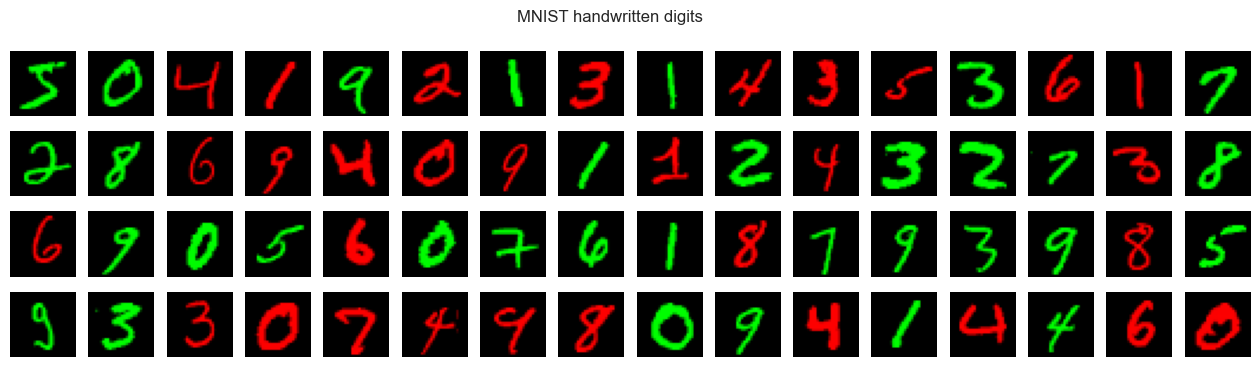

In [13]:
#plot a few CMNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample['image']
label = sample['label']
environment = sample['environment']

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].permute(1,2,0))
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

# Phase 1 - NF-iVAE

In [123]:
class iVariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(iVariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features

        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        ## setting the prior to a vector consisting of zeros with dimensions (1,2*latent_features)
        # self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
        '''
        According to page 31-32 the iVAE consist of 7 NNs:
        1. lambdaf prior
        
        2. X-encoder (Classic image CNN)
        3. (Y, E)-encoder
        4. (X, Y, E)-merger/encoder

        5. Decoder

        1: Learn priors based on the label distribution for the given environment
        2-4: Encoding X, encoding Y and E and merging these two encoders, to generate a 
             qz which is conditional on the environment.
        5: Decodes the latent space through pz. Since the latent space now contain some measure
           of environment, then this distribution pz is consequentially conditioned on the environment

        NN 1-3 can be found in the variational inference funktion.
        '''
        #### PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS ####
        #NN 1/5
        self.Lambdaf_prior = nn.Sequential(
            nn.Linear(in_features = 2, out_features=50), #Input
            # nn.Linear(in_features = 50, out_features=50), #Fully connected
            nn.ReLU(),
            nn.Linear(in_features = 50, out_features = 20))  #Output
        #### PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS ####

         #For NN 2/5 X-Encoder: Inference Network
         #Encode the observation `x` into the parameters of the posterior distribution
         #`q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoderCNN1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.encoderCNN2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.encoderCNN3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        ##NN 3/5 (Y, E)-Encoder
        self.YEencoder = nn.Sequential(
            nn.Linear(in_features = 2, out_features=100),
            # nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU())

        ##NN 4/5 (X, Y, E)-merger/encoder
        #remember to concatenate x.flatten, y, e before running this.
        self.XYEmerger = nn.Sequential(
            nn.Linear(in_features = 32 * 4 * 4 + 100, out_features=100),
            # nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features = 100, out_features = 2*latent_features))


        #For NN 5/5 (Decoder): Generative Model
        #Decode the latent sample `z` into the parameters of the observation model
        #`p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoderFFN = nn.Linear(in_features=latent_features, out_features = 32 * 4 * 4)
        self.decoderFFN2 = nn.Linear(in_features = 32 * 4 * 4, out_features = 32 * 4 * 4)
        
        self.decoderCNN1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 0)
        self.decoderCNN2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 1)
        self.decoderCNN3 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 1)

    def prior_params(self, y, e):
        """return the distribution `p(z)`"""
        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        lambdaf_parameters = self.Lambdaf_prior(ye)

        return lambdaf_parameters

    #NN 4/7
    def encoder(self, x, y, e):
        x = self.relu(self.encoderCNN1(x))
        x = self.relu(self.encoderCNN2(x))
        x = self.relu(self.encoderCNN3(x))
        x = x.view(x.size(0), -1) #NN 4/7

        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        ye = self.YEencoder(ye) #NN 5/7

        xye = torch.cat((x,ye), dim = 1)
        xye = self.XYEmerger(xye) #NN 6/7
    
        return xye
   
    #NN 7/7
    def decoder(self, z):
        
        x = self.relu(self.decoderFFN(z))
        # x = self.relu(self.decoderFFN2(x))
        
        # reshape x and add CNN decoder
        x = x.view(-1, 32, 4, 4)
        
        x = self.relu(self.decoderCNN1(x))
        x = self.relu(self.decoderCNN2(x))
        x = self.sigmoid(self.decoderCNN3(x))
        return x  
        
    def posterior(self, x:Tensor, y:Tensor, z:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x, y, z)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, y, e)-> Distribution:
        """return the distribution `p(z)`"""
        #Expand prior_params til at være samme antal rækker som i den valgte batch size således at der fås
        #en tensor med dimensionerne (batch_size, 2*latent_features), som så kan udfyldes med
        prior_params = self.prior_params(y, e)
        #chunk opdeler prior_params i to dele, de første 0-latent_features kollonner indeholder mu og 
        #de sidste n_latent_features inde holder sigmaerne. Nu er der to tensors, som begge har dim
        #(batch_size, n_latent_features). Værdierne i disse tensors, kan bruges til at sample hvordan
        #latent space ser ud (Den der hedder 'latent interpolations' i plots i bunden.)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        #BEMÆRK at at det er log_sigma, dvs. at når den inputtes i ReparameterizedDiagonalGaussian så fås mu = 0, sigma = 1
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_means = self.decoder(z)
        px_means = px_means.view(-1, *self.input_shape) # reshape the output #old
        log_var = 0.01 * torch.ones(px_means.shape)
        log_sigma = torch.log(torch.sqrt(log_var))
        #sandsynlighedsfordeling der giver 1 eller 0, baseret på log-odds givet i logits input fra p(x|z).
        #Dvs. at px_logits angiver sandsynligheden for at det givne pixel er henholdsvist rød,grøn,blå. Pixel værdien
        #er enten 0 eller 1. Når man sampler fra bernoulli fordelingen fås dermed et billede, som givet z, giver en figur,
        #som er bestemt af de sandsynligheder der er i px_logits (p(x|z)). Dvs. at for et givet latents space, kan en
        #figur/et tal reproduceres ud fra de beregnede sandsynligheder og den efterfølgende sample fra Bernoulli fordelingen.
        return ReparameterizedDiagonalGaussian(mu = px_means, log_sigma = log_sigma)
        

    def forward(self, x, y, e) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        ###############################################################################################
        # flatten the input
        #x = x.view(x.size(0), -1) #outcommented as part of adding CNN
        
        #### Run through ENCODER and calculate mu and sigma for latent space sampling
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x, y, e)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        #### LATENT SPACE
        z = qz.rsample()
        
        #### DECODER
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        ###############################################################################################
        
        # define the prior p(z)
        #(Indgår i beregning af kl-term (regularisering) ifm. ELBO) - og bruges også til interpolations visualisering
        #til sidst.
        pz = self.prior(y,e)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, y, e):
        """sample z~p(z) and return p(x|z)"""
        
        # Laver bare reconstruction baseret på latent space
        #Kan evt. fjernes. Anvendes bare til at vise hvor god modellen er til at generere data baseret på
        #latent space genererede data. Funktionen anvendes kun i make_vae_plots.
        
        # degine the prior p(z)
        pz = self.prior(y, e)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}
    
    def reduce(self, x:Tensor) -> Tensor:
        """for each datapoint: sum over all dimensions"""
        return x.view(x.size(0), -1).sum(dim=1)

    def VariationalInference(self, x, y, e, beta):
        self.beta = beta
        # forward pass through the model
        outputs = self.forward(x, y, e)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = self.reduce(px.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        log_pz = self.reduce(pz.log_prob(z)) #log(p(z)): Sandsynligheden for at observere vores latent space, givet at
        #latent space følger en standard-normal fordeling (Jo højere sandsynlighed jo bedre)
        log_qz = self.reduce(qz.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne værdi skal helst være lav?
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Forsøger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

latent_features = 10 #Husk at opdater denne parameter nede i 'initialization', hvis den skal bruges i VAE loopet også
ivae = iVariationalAutoencoder(images[0].shape, latent_features)
print(ivae)

iVariationalAutoencoder(
  (Lambdaf_prior): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
  )
  (encoderCNN1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderCNN2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderCNN3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (YEencoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
  )
  (XYEmerger): Sequential(
    (0): Linear(in_features=612, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
  )
  (decoderFFN): Linear(in_features=10, out_features=512, bias=True)
  (decoderFFN2): Linear(in_features=512, out_features=512, bias=True)
  (decoderCNN1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder

# ELBO

In [124]:
sample = next(iter(train_loader))
images = sample['image']
label = sample['label'].reshape(-1,1)
environment = sample['environment'].reshape(-1,1)

x = images
y = label
e = environment

In [125]:
beta = 1
loss, diagnostics, outputs = ivae.VariationalInference(x, y, e, beta)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =  27448.562, shape: []
elbo   | mean = -27448.562, shape: [256]
log_px | mean = -27446.168, shape: [256]
kl     | mean =      2.395, shape: [256]


In [126]:
from torchvision.utils import make_grid
def show_CMNIST(image, label, environment, ax):
    """Show image with landmarks"""
    ax.figure
    ax.imshow(image.permute(1,2,0))
    ax.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 8)
    ax.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 8)
    ax.axis('off')

# Initialization

In [127]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 10 #Hyper parameter
ivae = iVariationalAutoencoder(images[0].shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(ivae.parameters(), lr=1e-4) #Hyper parameter, tilføj evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


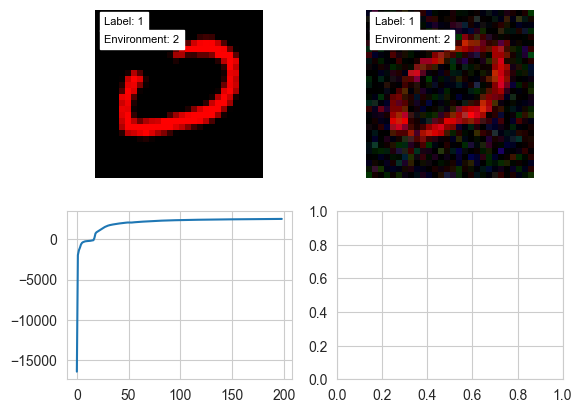

In [167]:
# torch.manual_seed(1)
optimizer = torch.optim.Adam(ivae.parameters(), lr=1e-4)
epoch = 0
num_epochs = 135 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
ivae = ivae.to(device)
sample_counter = 0
# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader: #tqdm
        sample_counter += 1
        
        x = sample['image']
        x = x.to(device)

        y = sample['label'].reshape(-1,1)
        y = y.to(device)

        e = sample['environment'].reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = ivae.VariationalInference(x, y, e, beta)
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    px = outputs['px']
    samples = px.sample()
    samples = samples.detach()

    fig, axes = plt.subplots(2,2)
    show_CMNIST(x[0], label=int(y[0]), environment=int(e[0]), ax = axes[0,0])
    show_CMNIST(samples[0], label=int(y[0]), environment=int(e[0]),  ax = axes[0,1])
    axes[1,0].plot(training_data['elbo'], label = "elbo")
    display(fig)
    clear_output(wait = True)


    #if (epoch+1)%(num_epochs*0.1) == 0:
        #print("epoch: {}: training loss: elbo = {}, kl = {}, log_px = {}, total loss = {}".format(epoch, training_data['elbo'][epoch-1], training_data['kl'][epoch-1], training_data['log_px'][epoch-1]), loss)
    
    #Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    #make_vae_plots(ivae, x, y, outputs, training_data, validation_data)

In [168]:
torch.save(ivae.state_dict(), 'ivae_JB_sigmoid200epoch.pt')

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


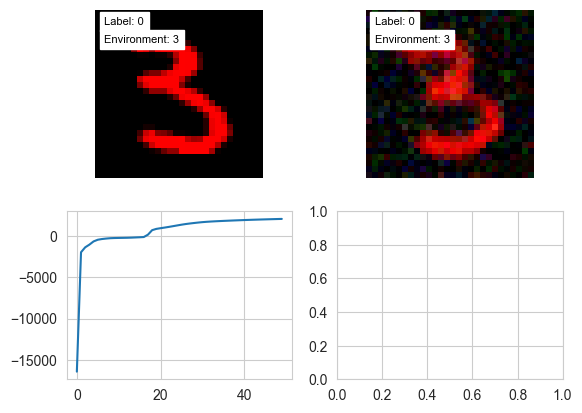

In [142]:
#ivae.load_state_dict(torch.load('30epochs.pt'))
#ivae.load_state_dict(torch.load('50epochs_withchanges_and_detached_pz_ELBO.pt'))
#Running model to test reconstruction on test data

sample = next(iter(test_loader))
x = sample['image']
y = sample['label'].reshape(-1,1)
e = sample['environment'].reshape(-1,1)
with torch.no_grad():
    output = ivae.forward(x, y, e)
    

px = output['px']
samples = px.sample()

fig, axes = plt.subplots(2,2)

sample_id = 3
show_CMNIST(x[sample_id], label=int(y[sample_id]), environment=int(e[sample_id]), ax = axes[0,0])
show_CMNIST(samples[sample_id], label=int(y[sample_id]), environment=int(e[sample_id]),  ax = axes[0,1])
axes[1,0].plot(training_data['elbo'], label = "elbo")
fig

In [144]:

plt.clf()
plt.close()
plt.show()


# Phase 2 - PC algorithm based on latent variable

(page 6-7)

In [145]:
#Dummy code for the testing of the PC algorithm to ensure the model data is prepared in the right format
import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport

#names = np.array(["A","B", "C", "D", "E"])
#data_df = pd.DataFrame(data, columns = names)
#pc_test = PC(CItest = 'gaussian', alpha = 0.05, verbose=False).create_graph_from_data(data_df[names[permutation]])

#nx.draw(pc_test, with_labels=True, font_weight='bold')
#plt.show()

### Implementing PC algorithm on CMNIST iVAE result ###
#load full CMNIST dataset --- determine causal latent variables based on training data
# -> assume ALL test data are reserved to after all training is done.
#cmnist_data1 = CMNISTDataset(pt_file = "data/ColoredMNIST/train1.pt"
#                            , environment = 1
#                            , transform = transform_to_tensor)
#cmnist_data2 = CMNISTDataset(pt_file = "data/ColoredMNIST/train2.pt"
#                            , environment = 2
#                           , transform = transform_to_tensor)

cmnist = ConcatDataset([cmnist_data1, cmnist_data2])
loader = DataLoader(cmnist, batch_size = 40000, batch_sampler = None)

sample = next(iter(loader))

x = sample['image']
y = sample['label'].reshape(-1,1)
e = sample['environment'].reshape(-1,1)

with torch.no_grad():
    output = ivae.forward(x, y, e)

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

In [146]:
z_df = pd.DataFrame(z.detach())
y_df = pd.DataFrame(y.detach())
e_df = pd.DataFrame(e.detach())

df = z_df; df['Y'] = y_df;# df['E'] = e_df

df.columns = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Y']#, 'E']
df.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Y
0,-16.985029,12.750794,26.561260,-10.646548,-28.720472,-0.661623,-11.888205,19.736868,5.904799,-12.187719,1
1,-23.086658,19.474836,19.091637,-28.116537,-10.547336,-7.797170,0.389493,23.093525,4.759761,-17.175915,0
2,9.212110,-3.746939,13.535967,1.852505,12.495205,-1.231672,6.839621,15.633656,-13.154624,-2.424784,0
3,-14.440510,-24.703747,7.674147,2.668855,-26.355394,-11.457851,-3.132242,14.021994,-17.436369,4.232144,0
4,-0.330947,-13.071881,20.948555,-12.101215,-5.672290,-7.395005,-14.956390,37.442905,-2.413355,-9.617546,1


In [137]:
#Testing that the format of the df is as expected
print(z[0])
print(df.iloc[0,])

tensor([-11.1197,   3.0926,  22.9081, -11.7847, -24.2953,   0.3076,  -8.0341,
         19.3284,   4.6917,  -9.9272])
Z1    -11.119703
Z2      3.092617
Z3     22.908070
Z4    -11.784686
Z5    -24.295275
Z6      0.307636
Z7     -8.034081
Z8     19.328434
Z9      4.691727
Z10    -9.927204
Y       1.000000
Name: 0, dtype: float64


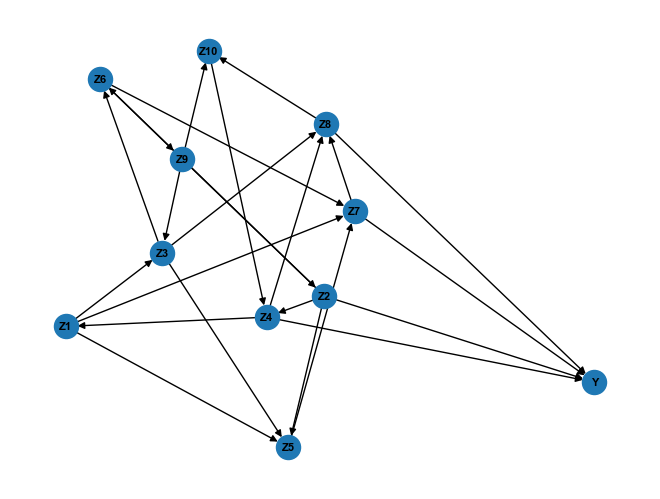

In [152]:
pc = PC(alpha=0.00001)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

In [153]:
pc_output.edges

OutEdgeView([('Z1', 'Z3'), ('Z1', 'Z5'), ('Z1', 'Z7'), ('Z2', 'Z4'), ('Z2', 'Z5'), ('Z2', 'Z6'), ('Z2', 'Y'), ('Z3', 'Z5'), ('Z3', 'Z6'), ('Z3', 'Z8'), ('Z4', 'Z1'), ('Z4', 'Z8'), ('Z4', 'Y'), ('Z5', 'Z7'), ('Z6', 'Z7'), ('Z6', 'Z9'), ('Z7', 'Z8'), ('Z7', 'Y'), ('Z8', 'Z10'), ('Z8', 'Y'), ('Z9', 'Z2'), ('Z9', 'Z3'), ('Z9', 'Z10'), ('Z10', 'Z4')])

In [154]:
#Found indices:
parents = torch.tensor([1,3,6,7])
options = np.array([0,1,2,3,4,5,6,7,8,9])
children = np.delete(options, parents)
nParents = len(parents)
nChildren = 10 - nParents

Determining the lambda parameters in equation (12) on page 7.

In [155]:
lambda1 = 1
lambda2 = 1

# Phase 3 - Learning an invariant predictor (classifier, *w*) based on the causal latent variables

(page 7)

#### CLASSIFIER, *w*

In [ ]:
#equation 12 p. 7 => Skal formodentligt bruges ifm. at køre data igennem test-sættet sådan at vi kan konvertere de kausale latente
#variable fra træningssættet til test-sættet.
#px = ivae.observation_model(z)
#log_px_z = px.log_prob(x)

In [156]:
#Accuracy function from week 4:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

#Building a classifier:

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #Layers
        self.input_layer = nn.Linear(in_features=4, out_features = 100)
        # self.layer1 = nn.Linear(in_features = 50, out_features = 100)
        self.output_layer = nn.Linear(in_features = 100, out_features = 1)

        #activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    #forward function(self, x):
    def forward(self, x):
        
        x = self.relu(self.input_layer(x))
        # x = self.relu(self.layer1(x))
        x = self.sigmoid(self.output_layer(x))

        return x
    # 

classifier = Classifier()
classifier.to(device)



Classifier(
  (input_layer): Linear(in_features=4, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [157]:
import torch.optim as optim
from sklearn import metrics

#Define loss function
loss_fn = nn.BCELoss() 
#The adam algorithm automatically use momentum
optimizer = optim.Adam(classifier.parameters(), lr = 1e-4) 

#Test model
z = output['z']
z = torch.index_select(z, 1, parents)
out = classifier(z[1])
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")

Output shape: torch.Size([1])
Output logits:
[0.04411285]


In [158]:
#Set iVAE to eval - the no.grad thing is not an issue as we are only using the encoder.
ivae.eval()

#TRAINING THE CLASSIFIER
epoch = 0
num_epochs = 10 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# training..
training_epoch_data = []
test_epoch_data = []
test_acc, train_acc = [], []

while epoch < num_epochs:
    epoch+= 1
    training_batch_data = []
    test_batch_data = []
    classifier.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        x = sample['image']
        x = x.to(device)

        y = sample['label'].to(torch.float32)
        y = y.to(device)

        e = sample['environment'].to(torch.float32)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        qz = ivae.posterior(x, y.reshape(-1,1), e.reshape(-1,1))
        z = qz.rsample()
        z = torch.index_select(z, 1, parents)

        #Get classification prediction
        output = classifier(z).view(-1)

        loss = loss_fn(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        training_batch_data.append(loss)
            

    # gather data for the full epoch
    training_epoch_data.append(torch.tensor(training_batch_data).mean())

    print("Epoch {} : , train loss {}".format(epoch, training_epoch_data[epoch-1]))


>> Using device: cpu
Epoch 1 : , train loss 0.9593124389648438
Epoch 2 : , train loss 0.47565194964408875
Epoch 3 : , train loss 0.44273629784584045
Epoch 4 : , train loss 0.436282217502594
Epoch 5 : , train loss 0.43276694416999817
Epoch 6 : , train loss 0.4302034080028534
Epoch 7 : , train loss 0.4281751215457916
Epoch 8 : , train loss 0.42652663588523865
Epoch 9 : , train loss 0.4250430166721344
Epoch 10 : , train loss 0.4238883852958679


In [159]:
test_data_full = DataLoader(cmnist_test_data, batch_size = 20000, batch_sampler = None)

sample = next(iter(test_data_full))

x_test = sample['image']
y_test = sample['label'].reshape(-1,1)
e_test = sample['environment'].reshape(-1,1)

output = ivae.forward(x_test, y_test, e_test)

z_test = output['z']

z_full = z_test.detach()
x_full = x_test.detach()
y_full = y_test.detach()
e_full = e_test.detach()

In [160]:
Zp = torch.randn(z_full.shape[0], nParents)
Zc = torch.randn(z_full.shape[0], nChildren)
Z = torch.randn(z_full.shape)

In [107]:
torch.cat([Zp, Zc], dim=1).shape

torch.Size([20000, 10])

In [161]:
#Check accuracy before running the eq12 algorithm
classifier.eval()
pred_y = classifier(Zp)
accuracy(torch.round(pred_y),y_full)

0.5004

Eq. 12 and classification based on test data

In [162]:
loss_BCE = nn.BCELoss()
num_epochs = 10

Zp.requires_grad = True
Zc.requires_grad = True

optimizerBCE = optim.Adam(params=[Zc, Zp], lr=0.002)#, weight_decay = 0.0002)
# optimizer = optim.Adam(params = [Zp, Zc], lr = 1e-3, weight_decay = 1e-8)

def get_reconstruction(Zp, Zc):
    Z[:,parents] = Zp
    Z[:,children] = Zc
    return(ivae.observation_model(Z))
    

for i in range(num_epochs):
    sample = next(iter(test_data_full))
    x = sample['image']
    # optimizer.zero_grad()
    optimizerBCE.zero_grad()

    px = get_reconstruction(Zp,Zc)
    reconstructions = px.sample()
    # reconstructions = torch.sigmoid(reconstructions)
    # reconstructions = reconstructions.contiguous()
    BCE = torch.nn.functional.binary_cross_entropy(reconstructions.view(-1,3*28**2), (x*0.5+0.5).view(-1,3*28**2), reduction = 'none')
    # print(BCE.mean(1))
    loss = BCE.mean(1)
    print(loss.mean())
    # loss = -px.log_prob(x)
    loss = loss.mean()

    loss.backward(retain_graph=True)
    # optimizerBCE.step()
    optimizerBCE.step()
    print(Z[0,:])
    print("Step done")


RuntimeError: all elements of input should be between 0 and 1

tensor([[[[ 0.4265,  0.5691,  0.4368,  ...,  0.3370,  0.2995,  0.2154],
          [ 0.4728,  0.4014,  0.4543,  ...,  0.3813,  0.3480,  0.3485],
          [ 0.3463,  0.4041,  0.4403,  ...,  0.2402,  0.2148,  0.2133],
          ...,
          [ 0.2821,  0.2091,  0.3266,  ...,  0.0711,  0.3043,  0.2953],
          [ 0.2095,  0.1386,  0.1282,  ...,  0.1091,  0.2146,  0.4679],
          [ 0.2500,  0.3996,  0.2459,  ...,  0.3642,  0.6185,  0.6418]],

         [[ 0.3241,  0.4393,  0.4031,  ...,  0.3975,  0.2490,  0.4408],
          [ 0.5907,  0.6205,  0.3024,  ...,  0.3354,  0.1731,  0.3322],
          [ 0.5285,  0.3256,  0.2173,  ...,  0.1727,  0.3274,  0.3389],
          ...,
          [ 0.2315,  0.0860,  0.2200,  ...,  0.2211,  0.2753,  0.3347],
          [ 0.0162,  0.1458,  0.1548,  ...,  0.2759,  0.3565,  0.4274],
          [ 0.3004,  0.2903,  0.1874,  ...,  0.2515,  0.3754,  0.2520]],

         [[ 0.3068,  0.5607,  0.3364,  ...,  0.4636,  0.2008,  0.3960],
          [ 0.1761,  0.1476,  

In [115]:
pred_y = classifier(Zp)
accuracy(torch.round(pred_y),y_full)

0.4971

In [52]:
cmnist = ConcatDataset([cmnist_data1, cmnist_data2])
loader = DataLoader(cmnist, batch_size = 40000, batch_sampler = None)

sample = next(iter(loader))

x = sample['image']
y = sample['label'].reshape(-1,1)
e = sample['environment'].reshape(-1,1)
with torch.no_grad():
    output = ivae.forward(x, y, e)

z = output['z']

z_train = z.detach()
x_train = x.detach()
y_train = y.detach()
e_train = e.detach()

In [53]:
with torch.no_grad():
    qz = ivae.posterior(x_train, y_train.reshape(-1,1), e_train.reshape(-1,1))
    z = qz.rsample()
    Zp_train = torch.index_select(z, 1, parents)
pred_y_train = classifier(Zp_train)
print(accuracy(torch.round(pred_y_train),y_train))

0.8512712817820446


In [54]:
with torch.no_grad():
    qz = ivae.posterior(x_full, y_full.reshape(-1,1), e_full.reshape(-1,1))
    z = qz.rsample()
    Zp_test = torch.index_select(z, 1, parents)
pred_y_test = classifier(Zp_test)
print(accuracy(torch.round(pred_y_test),y_full))

0.1025


In [33]:
px = ivae.observation_model(z_full)
log_px = px.log_prob(x_full)

In [34]:
n_parents = len(indices)
options = np.array([0,1,2,3,4,5,6,7,8,9])
ivae.eval()

nll = []

with torch.no_grad():
    for i in range(0,10):
        px = ivae.observation_model(z_full)
        
        nll_temp = -(px.log_prob(x_full).sum() + lambda1*torch.norm(z_full[:,i]).sum() + lambda2*torch.norm(z_full[:,children].sum()))
        nll.append(nll_temp)
        print("done i = {}".format(i))

    

done i = 0
done i = 1
done i = 2
done i = 3
done i = 4
done i = 5


: 

: 

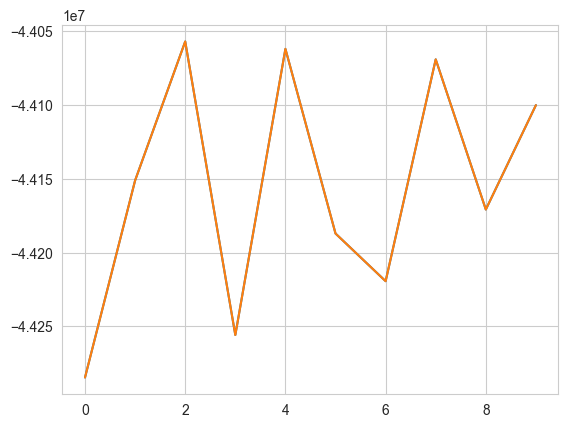

In [33]:
np.argmin(nll)
plt.plot(nll)
plt.show()